# Abstract

In this project I developed a website classification algorithm. 

I took a small subset of a large dataset that contained class labels for urls. Using these urls, I scraped the html from the associated websites, and used this as the input data for an NLP algorithm. I tested two algorithms, the Naive Bayes, and Support Vector Machine. After Bayesian Hyperparameter Optimization and cross validation, the best performing algorithm was the Support Vector Machine with a cross-validation accuracy of 60.7%. This algorithm went on show an accuracy of 59.0% on the test set.

Finally I used this algorithm to classify the Coldstart files. The results of which were printed to csv. 

Further work to improve performance could look at using a larger subset of the dataset for algorithm development, as well as using a more sophisticated algorithm such as transfer learning with a pre-trained neural network with transformer architecture. 

# Strategy

## Possible approaches

Because the data is not labelled and I am allowed to select my own classes, I have a few options for developing a model for classifying this dataset.

1) Use an unsupervised algorithm to cluster the samples, then look at these clusters and give them labels based on how I interpret them.

2) Label some or all of the data myself and use a supervised or semi-supervised approach.

3) Find labelled data online for an identical or similar dataset, build a classification model using this dataset, then apply it.

## Selected approach

Approach 1) This could work, but the clusters could end up being uninterpretable and thus not useful. 

Approach 2) Would be time consuming and isn't very scaleable if I needed more data for improved accuracy.

Because of the above reasons, I went with approach 3). I was able to find a dataset online that contained over 1 million labelled urls. Using these urls, I could scrape the raw html, preprocess it, and feed this to a NLP classifier along with the label, and build a model that should generalize well to the Coldstart dataset.

## Imports

In [10]:
import requests
import re
import os

import pandas as pd

from bs4 import BeautifulSoup
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from bayes_opt import BayesianOptimization

## Dataset

Because scraping 1 million websites would take a long time, I wrote a script that took 50 urls from each class and created a new smaller dataset. I did not include this code here, but it can be found in the file "data_subset_generation.py" in this repo. This smaller dataset is loaded in below.

In [3]:
labelled_url = pd.read_csv('URL classification downsampled.csv')

# Data Pre-Processing

## Generating/Scraping Data
The html associated with a url can be scraped using python's requests library. After scraping the raw html, I use the Beautiful Soup library to parse and extract the useful content from the html file. This allows me to easily extract the text content from the page while ignoring the html syntax. I then package this text, along with the associated label, into an object from the LabelledDatapoint class created below, and repeat for each URL. By storing the data in a list of objects, it makes writing to a database very simple. One process can be created for this (writing a list of LabelledDatapoint objects to a database or other data storage location), and then additional processes for importing and converting data from other data sources into these objects can be built on top of this.

Finally, I convert this data into a list of texts ("Corpus"), and a list of labels. 

In [4]:
# This class will be used to hold the useful contents that were parsed using Beautiful Soup.
class LabelledDatapoint:    
    def __init__(self, contents, label):
        self.contents = contents
        self.label = label

def parse_html_contents(html):
    """
    This function accepts the html code as a string and parses it to return the text content of the page.
    
    Parameters
    ----------
    html_file : String
        HTML code.

    Returns
    -------
    contents : string
        The parsed text contents of an html file.
    """    
    
    soup = BeautifulSoup(html, 'html.parser')
    # Add space if next character is not lowercase. For example "HelloWorld!Hello@World" becomes "Hellow World ! Hello @ World"
    contents = ' '.join(re.split('(?=[^a-z]])', soup.text))
    
    return contents
        
def generate_labelled_datapoint(url, label):
    """
    This function accepts a url and a classification label, and returns a LabelledDatapoint object.

    Parameters
    ----------
    url : String
        The url of the website.
    label : String
        Classification label for the corresponding url.

    Returns
    -------
    LabelledDatapoint : Object
        Returns a LabelledDatapoint object that holds the html contents and class label.
    """
    
    r = requests.get(url)
    contents = parse_html_contents(r.text)
    
    return LabelledDatapoint(contents, label)

In [6]:
dev_dataset  = []
bad_websites = []
for domain, label in tqdm(zip(labelled_url['URL'],labelled_url['Category'])):
        
    # Some of the websites will throw errors so I wrapped in a try block to ignore. log the bad url, and keep going.
    try: 
        dev_dataset.append(generate_labelled_datapoint(domain, label))
    except Exception:
        bad_websites.append(domain)
        
corpus = [x.contents for x in dev_dataset] # The text content of the html page.
labels = [y.label for y in dev_dataset] # The class labels.

550it [28:56,  3.16s/it]


## Class Imbalance
In any classification task, it is a good idea to look at the distribution of samples for each class. Unbalanced classes can lead to biases within the algorithm (e.g. Classes that appeared more frequently in the training set could cause the algorithm to bias towards that class). In some cases, this may be desirable, such as instances where the class imbalance is reflective of the true distribution of classes. If the class imbalance is not reflective of the true class frequency, it could lead to overfitting towards the overrepresented classes.

In this task, it is hard to know what the true class frequency should be, therefore an even class distribution in the training data is acceptable. In the preprocessing, 50 samples per class were selected and scraped. Due to errors with some of the websites, not all samples will be used. The final class frequencies are plotted below.

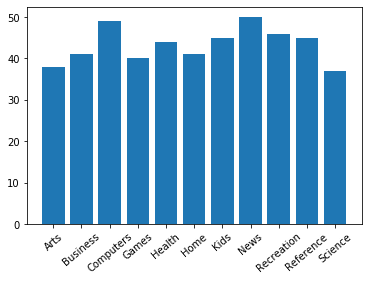

In [16]:
plt.bar(*zip(*Counter(labels).items()))
plt.xticks(rotation=40)
plt.show()

While the classes are not perfectly balanced, they are fairly even. Because of this, fully balancing the classes would likely have marginal benefits. If the classes were significatly more uneven, undersampling or oversampling could be a good strategy.

## Preprocessing

Before the html text contents can be fed to the machine learning algorithms, it must be further processed. 

First, I vectorize the words contained within all of the website content. This creates an array for each sample that contains the number of occurances of each word.

Next, I use a TFIDF (Transform term-frequency times inverse document-frequency) transform to normalize the words within the word vectors. This type of normalizion scales words based on their frequency across all samples. This results in less emphasis being placed on words that occur frequently across all samples, as these are less likely to be useful for classification. 

Finally, the data is split into two sets. The training/validation set and a test set. The training/validation set will be used with k-fold cross validation for hyperparameter tuning and algorithm selection, and the test set will be used to get a performance estimate of the final model.

In [75]:
# Vectorize the counts.
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)

# Transform term-frequency times inverse document-frequency.
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X)

# Split into a training/cross-validation set and test set.
X_train_val, X_test, y_train_val, y_test = train_test_split(X_tfidf, labels, test_size=0.25, random_state=20)

# Model Selection and Hyperparameter Optimization

Now that the data is preprocessed, it is time to test and optimize some models. 

## Models to be Tested

I will not be implementing any neural network architectures. From my understanding, NLP neural networks require large networks with a high number of parameters and as a result are very slow to train (especially on my computer with no dedicated GPU). Additionally, I am using a very small training set, and a large neural network architecture would likely overfit this data.

Given more computing power and a larger dataset. My understanding is the approach that would result in the highest level of accuracy would be to take a large pre trained network with a transformer architecture such as XLnet, and use a transfer learning approach to tune it to this use case.

Instead, I will be testing two more basic machine learning algorithms that have been succesful in the NLP Domain, the Support Vector Machine, and Naive Bayes.

## Bayesian Hyperparameter Optimization

In general, many machine learning algorithms have a set of hyperparameters that define how the model will perform. These hyperparameters are paramaters used in the algorithm that are not adjusted during the training process.

It is often difficult to know in advance which set of hyperparameters will lead to an optimal result, particularily in more complicated models such as neural networks. Because of this, tuning these parameters often involves testing a bunch of sets of parameters and using whichever set gives the best result.

Two common approaches to this are called grid search and random search. In these, you test a number of sets of parameters that exist within a hyperparameter space you define. In grid search, you search through the whole hyperparameter space, testing each point. In random search, you test a number of random samples from the hyperparameter space.

While these approaches work, they are largely ineffient as they do not use previous results to inform the next set of parameters to be tested. 

This is where Bayesian Hyperparameter Optimization comes in. This algorithm uses the previous results to inform the next set of hyperparameters to be tested, and can help target areas of the hyperparameter space that show the most promise. It begins by randomly sampling a few sets of parameters from a predefined hyperparameter space, just like a random search. After a few iterations, it can then use the results of the these samples to create a probability distribution of predicted performance outcomes for each point in the hyperparameter space. It will then use these probability distributions to inform the next point to be chosen.

Bayesian Hyperparameter Optimization is particularily useful for optimizing functions that are costly to evaluate. By using prior tests to inform future hyperparameter samples, it can save time by avoiding regions of the hyperparameter space that show little promise.

## Model Evaluation

Through the model evaluation and hyperparameter optimization stages I will use k-fold cross validation to evaluate the model, with accuracy being used as the metric to optimize. Accuracy is a useful metric for this type of multi-class classification because in general the classes are balanced, and we have no special interest in any one class.

If it was very important to not misclassify certain classes, the sensitivity or specificity of those classes could be used as other performance metric options.

In [18]:
"""
Because the Bayesian Optimization library only allows hyperparameters (and not training data) to be passed 
to the objective function, I declare Training/Validation globally so that it can be used within the objective function. 
"""
global X_train_val
global y_train_val

## Support Vector Machine Hyperparameter Optimization

In [19]:
def objective_function_SVM(alpha_power, l1_ratio):
    
    kf = KFold(n_splits=5)    
    accuracy_list = []
    
    # Implementing K-fold (k=5) cross validation and using the result to inform bayesian optimizaiton.
    for train_index, val_index in kf.split(X_train_val):
        
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train = [y_train_val[x] for x in train_index]
        y_val =  [y_train_val[y] for y in val_index]
                
        alpha = 0.1**alpha_power #Because we want alpha to be log-uniformly distributed and pbounds only generates values uniformly.       
        
        # Building the model, by using elasticnet we can optimize a linear combination of l1 and l2 regularization methods.
        SVM = SGDClassifier(penalty='elasticnet',l1_ratio=l1_ratio,alpha = alpha)
        SVM.fit(X_train, y_train)
    
        y_pred = SVM.predict(X_val)        
        accuracy_list.append(accuracy_score(y_val, y_pred))
    
    return sum(accuracy_list)/len(accuracy_list)
    
# Defining the hyperparamter space, values are generated from a uniform distribution bounded by this space.
pbounds = {'alpha_power': (1, 7), 'l1_ratio': (0,1)}
   
optimizer_SVM = BayesianOptimization(
    f=objective_function_SVM,
    pbounds=pbounds,
    random_state=100,
    verbose = 1
)

# Randomly sample 3 points within hyperparameter space and then using bayesian predictions for the next 100 points.    
optimizer_SVM.maximize(
    init_points=3,
    n_iter=100,
)

|   iter    |  target   | alpha_... | l1_ratio  |
-------------------------------------------------
|  9        |  0.5912   |  3.369    |  0.0      |
|  14       |  0.5966   |  2.963    |  0.0      |
|  16       |  0.5994   |  3.125    |  0.0166   |
|  30       |  0.6022   |  2.026    |  0.0      |
|  51       |  0.6023   |  3.575    |  0.0575   |
|  53       |  0.605    |  3.678    |  0.2428   |
|  65       |  0.6052   |  3.582    |  0.07551  |
|  95       |  0.6078   |  2.971    |  0.008333 |


## Naive-Bayes  Hyperparameter Optimization

In [22]:
def objective_function_NB(alpha):
    
    kf = KFold(n_splits=5)    
    accuracy_list = [] # Holds cross-validation results for each fold.
    
    for train_index, val_index in kf.split(X_train_val):
        
        # Set train and validation data for this fold.
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train = [y_train_val[x] for x in train_index]
        y_val =  [y_train_val[y] for y in val_index]
        
        # Create and Train Model.
        NB = MultinomialNB(alpha = alpha)
        NB.fit(X_train, y_train)
        
        # Evaluate model for this fold.
        y_pred = NB.predict(X_val)        
        accuracy_list.append(accuracy_score(y_val, y_pred))
    
    return sum(accuracy_list)/len(accuracy_list)

# Defining the hyperparamter space, values are generated from a uniform distribution bounded by this space.
pbounds = {'alpha': (0, 3)}
   
optimizer_NB = BayesianOptimization(
    f=objective_function_NB,
    pbounds=pbounds,
    random_state=100,
    verbose = 1
)
    
# Randomly sample 3 points within hyperparameter space and then using bayesian predictions for the next 100 points.    
optimizer_NB.maximize(
    init_points=3,
    n_iter=30,
)

|   iter    |  target   |   alpha   |
-------------------------------------
|  2        |  0.3695   |  0.8351   |
|  4        |  0.4004   |  0.3337   |


C:\Users\Kip\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\Kip\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\Kip\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\Kip\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\Kip\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in

|  5        |  0.4455   |  2.22e-16 |


C:\Users\Kip\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\Kip\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\Kip\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\Kip\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\Kip\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in

|  8        |  0.5378   |  0.000132 |
|  10       |  0.5406   |  0.000140 |
|  11       |  0.5603   |  0.000906 |
|  14       |  0.5631   |  0.002011 |
|  15       |  0.5631   |  0.002388 |
|  20       |  0.5631   |  0.00498  |


In [26]:
print(optimizer_NB.max["target"])

0.5631455399061032


In [27]:
print("The best Naive Bayes result was:")
print(optimizer_NB.max)
print("The best SVM result was:") 
print(optimizer_SVM.max)

The best Naive Bayes result was:
{'target': 0.5631455399061032, 'params': {'alpha': 0.004980237342883331}}
The best SVM result was:
{'target': 0.6078247261345853, 'params': {'alpha_power': 2.971352213150845, 'l1_ratio': 0.008332754510908646}}


# Final Model 
## Evaluating on Test Set

After hyperparameter tuning, the, best model was the Support Vector Machine with alpha = 0.001068 (0.1^2.97) and l1_ratio = 0.0083. This model had a cross validation accuracy of 60.7%. This model will now be evaluated on the test set to give a final performance score, and then used on the final dataset for classification.

The model's accuracy was 59.0% on the test set


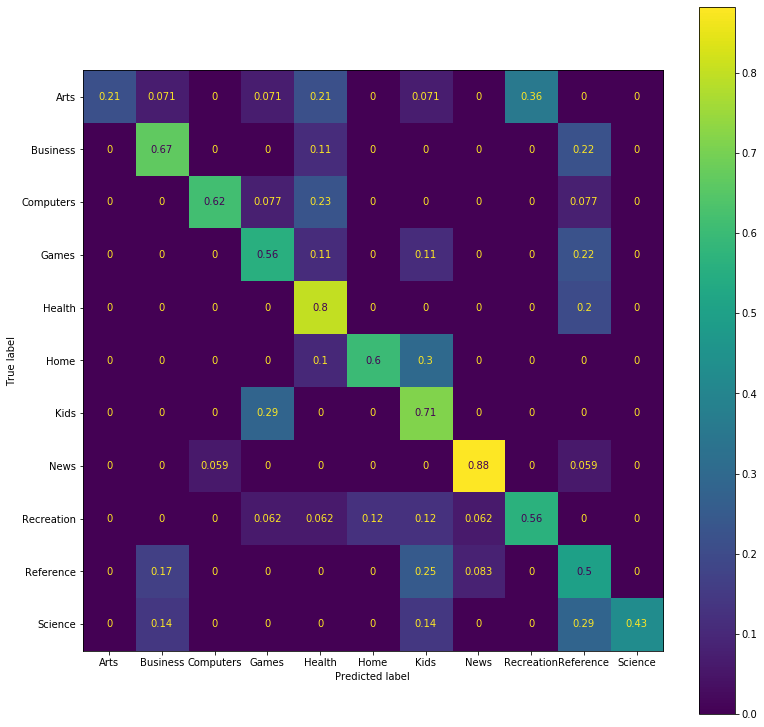

In [71]:
final_model = SGDClassifier(penalty="elasticnet", l1_ratio=optimizer_SVM.max["params"]["l1_ratio"],alpha = (0.1**optimizer_SVM.max["params"]["alpha_power"]))
final_model.fit(X_train_val, y_train_val)

y_pred_test = final_model.predict(X_test)

print("The model's accuracy was " +  str(round(100*accuracy_score(y_test, y_pred_test))) + "% on the test set")
fig, ax = plt.subplots(figsize=(13, 13))
plot_confusion_matrix(final_model,X_test,y_test, normalize='true', ax=ax)

On the test set the model had an accuracy of 59%. Looking at the confusion matrix, the algorithm was most succesful at identifying news websites. We can also see that it was heavily biased towards health and kids websites, both seeing a high false positive rate.

## Reading Coldstart Data

In general, the framework will be to store the url and text contents in an UnlabelledDatapoint object. In this case, I have defined a function that will read and process the html files in the folder of the path provided and store the url and text contents in UnlabelledDatapoint objects. Just like the labelled datapoint objects in the development stage, the list of objects allows each datapoint to remain packaged, and intermediary processes can be built and adjusted based on need. New datasources simply need processes to read and repackag data into UnlabelledDatapoint objects.

In [72]:
class UnlabelledDatapoint:    
    def __init__(self, url, contents):
        self.url = url
        self.contents = contents        
        
def batch_HTML_scrape_from_folder(path):
    
    """
    This function accepts a local path to a folder of html files, and returns a list of UnlabelledDatapoint objects.

    Parameters
    ----------
    path : String
        The path to the folder of html files.
    
    Returns
    -------
    html_datapoint_list : List
        Returns a List of UnlabelledDatapoint objects, one for each html file.
    """
    
    
    html_datapoint_list = []        
    
    for filename in os.listdir(path): # Loop through all of the files in the directory.
        
        html = open(path + "\\" + filename, "r", errors='replace').read()        
        text_contents = parse_html_contents(html)
        
        HTML_datapoint = UnlabelledDatapoint(filename,text_contents)            
        html_datapoint_list.append(HTML_datapoint)    
    
    return html_datapoint_list

html_to_classify = batch_HTML_scrape_from_folder("temp_data/preprod-coldstart-scraping")
corpus_to_classify = [x.contents for x in html_to_classify]

Now we apply the same vectorization and normalization steps that we did with the development dataset, although this time we don't refit the word vectorizer and normalizer. Then the data is fed into the algorithm to make predictions.

In [76]:
# Vectorize the counts.
X_cs = vectorizer.transform(corpus_to_classify)

# Transform term-frequency times inverse document-frequency.
X_tfidf_cs = tfidf_transformer.transform(X_cs)

# Classifying the Coldstart Webpages.
coldstart_pred = final_model.predict(X_tfidf_cs)

Because there are no labels for the Coldstart data, we can't evaluate the performance, but we can look at the class frequency of the websites.

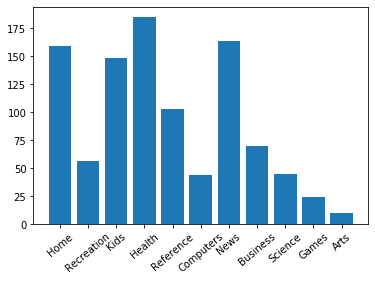

In [78]:
plt.bar(*zip(*Counter(coldstart_pred).items()))
plt.xticks(rotation=40)
plt.show()

It looks like the majority of websites are home, kids, health, and news. Although because of the high false positive rate of the kids and health classes, they could likely be overrepresented above. Finally, we can push the labels and urls to a dataframe and spot check the results.

In [81]:
urls = [x.url for x in html_to_classify]

df_results = pd.DataFrame(
            {'URL': urls,
             'Labels': list(coldstart_pred)
            })

print(df_results.iloc[0:20,:])

                               URL      Labels
0                       123.hp.com        Home
1                        7mesh.com  Recreation
2   acronyms.thefreedictionary.com        Kids
3                 adultmmogame.com      Health
4          ageofempires.fandom.com   Reference
5                        ai.google   Computers
6               airflow.apache.org   Computers
7      alphabytesoup.wordpress.com      Health
8            alsdinternational.com        News
9               alysivji.github.io      Health
10                       anchor.fm        News
11              andrewcmaxwell.com      Health
12          anymail.readthedocs.io      Health
13                   app.slack.com        Home
14                    applique.com  Recreation
15                   arescadon.com        News
16                arrow.fandom.com   Reference
17                 arstechnica.com      Health
18           askabiologist.asu.edu        Kids
19             atlantic.ctvnews.ca        News


In [83]:
df_results.to_csv("Coldstart Data Labelled.csv")